# 🛡️ VisionGuard

**VisionGuard** é uma aplicação web para **monitoramento inteligente por vídeo**, com detecção em tempo real de **objetos cortantes** e identificação da presença de **pessoas na cena**, permitindo classificar contextualmente os alarmes como:

- 🔪 **Objeto cortante detectado**
- 🧍‍♂️🔪 **Pessoa com objeto cortante detectado**

A aplicação pode ser usada com a **webcam ao vivo** ou por **vídeos enviados** via upload. Alarmes são exibidos na interface e enviados por e-mail com imagem, além da geração de **relatórios automáticos em PDF**.

Neste notebook, vamos realizar o treinamento de um modelo YOLO (You Only Look Once) para detecção de objetos cortantes. Utilizando um dataset específico, o objetivo é treinar uma rede neural para identificar e localizar facas e outros objetos cortantes em imagens.

A primeira parte do código instala o YOLOv8, preparando o ambiente para tarefas de detecção de objetos cortantes.

A segunda parte monta o Google Drive, permitindo o acesso e armazenamento de arquivos necessários para o projeto.

Ao final do treinamento, o modelo gerado será salvo no formato .pt (PyTorch), pronto para ser utilizado na aplicação VisionGuard, para a detecção de objetos cortantes em imagens ao vivo ou vídeos.

#Etapa 1: Instalar o YOLOv8 (Ultralytics)

In [1]:
!pip install ultralytics --quiet
from google.colab import drive
drive.mount('/content/drive')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.8/978.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.2 MB/s eta 0:00:00
Mounted at /content/drive


#👇 Etapa 2: Upload do dataset ZIP manualmente (use a barra lateral do Colab ou este código)

In [2]:
from google.colab import files  #Importa o módulo files do pacote google.colab, que fornece funcionalidades para interagir com arquivos no ambiente do Google Colab.

print("👉 Envie o arquivo ZIP do seu dataset (ex: knife-dataset-new.zip)")
uploaded = files.upload() #o Método files.upload() permite que você faça upload de arquivos do seu computador local para o ambiente do Colab.


👉 Envie o arquivo ZIP do seu dataset (ex: knife-dataset-new.zip)


Saving knife-dataset-new.v1-version-1-with-out-background-.yolov8.zip to knife-dataset-new.v1-version-1-with-out-background-.yolov8.zip


#✅ Etapa 3: Descompactar o dataset

🗂️ Conteúdo da pasta /content/:
['.config', 'README.roboflow.txt', 'train', 'yolov8s.pt', 'knife-detection', 'valid', 'drive', 'test', 'data.yaml', 'README.dataset.txt', 'yolo11n.pt', 'knife-dataset-new.v1-version-1-with-out-background-.yolov8.zip', 'sample_data']
📁 Subpastas no dataset:
['.config', 'README.roboflow.txt', 'train', 'yolov8s.pt', 'knife-detection', 'valid', 'drive', 'test', 'data.yaml', 'README.dataset.txt', 'yolo11n.pt', 'knife-dataset-new.v1-version-1-with-out-background-.yolov8.zip', 'sample_data']


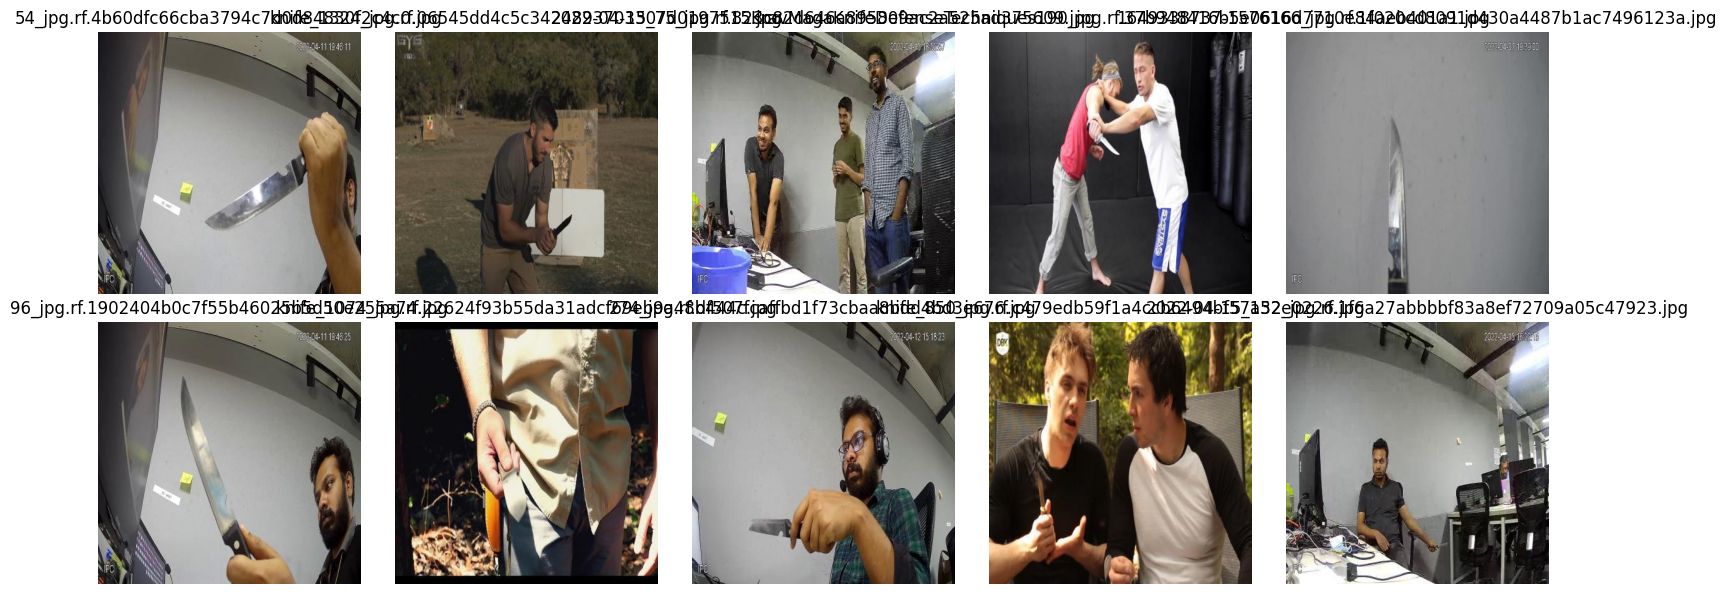

In [6]:
import zipfile  #zipfile: módulo da biblioteca padrão do Python que permite trabalhar com arquivos ZIP.
import os    #os: módulo que fornece funções para interagir com o sistema operacional, como listar diretórios.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # módulos para visualização das imagens

# Pega o nome do arquivo enviado, uploaded é um dicionário contendo os arquivos enviados pelo usuário. O next(iter(uploaded)) obtém o nome do primeiro arquivo enviado.
dataset_zip = next(iter(uploaded))


# Extrai o conteúdo :Abre o arquivo ZIP em modo de leitura ('r').Extrai todo o conteúdo do arquivo ZIP para o diretório /content/.O uso do with garante que o arquivo ZIP será fechado corretamente após a extração.
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/")

# Verifica o que foi extraído
print("🗂️ Conteúdo da pasta /content/:")
print(os.listdir("/content/"))

# Define o nome correto da pasta extraída
dataset_path = "/content/"

# Verifica subpastas internas
print("📁 Subpastas no dataset:")
print(os.listdir(dataset_path))

# Função para buscar imagens recursivamente
def get_image_files(path, extensions=('jpg', 'jpeg', 'png')):
    image_files = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.lower().endswith(extensions):
                image_files.append(os.path.join(root, file))
    return image_files

# Obtém imagens
image_files = get_image_files(dataset_path)

# Exibe até 10 imagens
num_images = min(10, len(image_files))

plt.figure(figsize=(15, 6))

for i in range(num_images):
    img = mpimg.imread(image_files[i])
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(os.path.basename(image_files[i]))

plt.tight_layout()
plt.show()



# ✅ Etapa 4: Treinar modelo YOLOv8 com seu dataset


In [4]:
from ultralytics import YOLO #Importa a classe YOLO da biblioteca Ultralytics, que fornece funcionalidades para treinamento, validação e inferência de modelos YOLOv8.

# Carrega o modelo pré-treinado YOLOv8 Small (yolov8s.pt). Este modelo serve como ponto de partida para o treinamento com seu dataset personalizado.
#Você pode optar por modelos de diferentes tamanhos, como:
#yolov8n.pt (Nano): Mais rápido, porém menos preciso.
#yolov8m.pt (Medium): Compromisso entre velocidade e precisão.
#yolov8l.pt (Large) e yolov8x.pt (Extra Large): Mais precisos, porém mais lentos e exigentes em recursos computacionais.
model = YOLO("yolov8s.pt")


# Inicia o treinamento
model.train(
    data=f"{dataset_path}/data.yaml",   #data: Caminho para o arquivo data.yaml, que deve conter as configurações do seu dataset, como caminhos para as imagens de treinamento e validação, além das classes.
    epochs=50,#epochs: Define o número de vezes que o modelo irá percorrer todo o dataset durante o treinamento. Mais épocas podem levar a um modelo mais preciso, mas também aumentam o tempo de treinamento.
    imgsz=640,#imgsz: Especifica o tamanho das imagens de entrada. O padrão é 640x640 pixels, mas pode ser ajustado conforme necessário.
    batch=16,#batch: Determina quantas imagens serão processadas simultaneamente durante o treinamento. Um valor maior pode acelerar o treinamento, mas requer mais memória GPU.
    project="knife-detection",#project: Nome do projeto, utilizado para organizar os resultados e checkpoints do treinamento.
    name="yolov8-train"#name: Nome específico para esta execução do treinamento, permitindo diferenciar entre diferentes experimentos dentro do mesmo projeto.
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 21.5M/21.5M [00:00<00:00, 571MB/s]


Ultralytics 8.3.111 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content//data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=knife-detection, name=yolov8-train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

100%|██████████| 755k/755k [00:00<00:00, 92.9MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 428MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 803.1±299.0 MB/s, size: 24.9 KB)


train: Scanning /content/train/labels... 2893 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2893/2893 [00:01<00:00, 1530.55it/s]


train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 561.3±246.4 MB/s, size: 18.6 KB)


val: Scanning /content/valid/labels... 797 images, 0 backgrounds, 0 corrupt: 100%|██████████| 797/797 [00:00<00:00, 1322.64it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to knife-detection/yolov8-train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to knife-detection/yolov8-train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       3.8G      1.922      2.775      1.814         27        640: 100%|██████████| 181/181 [00:18<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.87it/s]


                   all        797        849      0.231      0.337      0.154     0.0526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       4.6G      2.094      2.327      2.016         22        640: 100%|██████████| 181/181 [00:16<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.56it/s]


                   all        797        849       0.17      0.317      0.114     0.0384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.63G      2.084      2.369      2.027         29        640: 100%|██████████| 181/181 [00:16<00:00, 11.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.70it/s]


                   all        797        849      0.187      0.252     0.0978      0.033

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.67G      2.036      2.275      2.006         25        640: 100%|██████████| 181/181 [00:16<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.50it/s]


                   all        797        849      0.506      0.379      0.349      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.71G      1.956      2.107      1.912         23        640: 100%|██████████| 181/181 [00:16<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.60it/s]

                   all        797        849      0.608      0.462      0.507      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.74G       1.87      1.947      1.867         23        640: 100%|██████████| 181/181 [00:16<00:00, 11.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.63it/s]

                   all        797        849      0.615      0.448      0.473      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.78G      1.788        1.8      1.799         28        640: 100%|██████████| 181/181 [00:16<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.61it/s]

                   all        797        849      0.597      0.557      0.552      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.81G      1.773      1.759      1.772         15        640: 100%|██████████| 181/181 [00:16<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.72it/s]

                   all        797        849      0.712        0.6      0.678      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.85G      1.743      1.695      1.751         21        640: 100%|██████████| 181/181 [00:16<00:00, 11.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.74it/s]

                   all        797        849      0.666      0.629      0.666      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.88G      1.707      1.628      1.721         25        640: 100%|██████████| 181/181 [00:16<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.64it/s]

                   all        797        849      0.748      0.627      0.715      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.92G      1.677      1.573      1.686         26        640: 100%|██████████| 181/181 [00:16<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.63it/s]

                   all        797        849      0.747       0.68      0.747      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.96G      1.674      1.536      1.681         24        640: 100%|██████████| 181/181 [00:16<00:00, 11.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.84it/s]

                   all        797        849      0.778      0.622      0.736      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.99G      1.646      1.462      1.654         19        640: 100%|██████████| 181/181 [00:16<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.69it/s]

                   all        797        849      0.771      0.677      0.755      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.03G      1.606      1.418      1.638         24        640: 100%|██████████| 181/181 [00:16<00:00, 11.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.65it/s]

                   all        797        849      0.853      0.664      0.794      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.07G      1.592      1.398      1.628         32        640: 100%|██████████| 181/181 [00:16<00:00, 11.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.73it/s]

                   all        797        849      0.834      0.683      0.792      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       5.1G      1.595      1.415      1.624         13        640: 100%|██████████| 181/181 [00:16<00:00, 11.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.73it/s]

                   all        797        849        0.8      0.696      0.773      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.14G      1.567      1.295      1.583         18        640: 100%|██████████| 181/181 [00:16<00:00, 11.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.76it/s]

                   all        797        849      0.822      0.713      0.812       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.18G      1.561      1.297      1.587         15        640: 100%|██████████| 181/181 [00:16<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.79it/s]

                   all        797        849      0.813       0.74      0.822      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.21G      1.539      1.287      1.583         26        640: 100%|██████████| 181/181 [00:15<00:00, 11.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.60it/s]

                   all        797        849      0.836      0.763      0.838      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.25G       1.52      1.251      1.554         17        640: 100%|██████████| 181/181 [00:16<00:00, 11.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.67it/s]

                   all        797        849      0.857      0.755      0.832      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.29G       1.51      1.205      1.548         17        640: 100%|██████████| 181/181 [00:16<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.47it/s]

                   all        797        849      0.858      0.742      0.833      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.32G      1.506      1.201      1.545         22        640: 100%|██████████| 181/181 [00:16<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.69it/s]

                   all        797        849      0.825      0.786      0.852      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.36G      1.473      1.179      1.516         22        640: 100%|██████████| 181/181 [00:16<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.78it/s]

                   all        797        849      0.858      0.749      0.848      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.39G      1.435      1.149      1.497         28        640: 100%|██████████| 181/181 [00:16<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.56it/s]

                   all        797        849      0.813       0.79      0.839      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.43G      1.431      1.117      1.483         26        640: 100%|██████████| 181/181 [00:16<00:00, 11.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.87it/s]

                   all        797        849      0.898      0.779      0.874      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.47G      1.434      1.106      1.491         23        640: 100%|██████████| 181/181 [00:16<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.73it/s]

                   all        797        849      0.857       0.81      0.882      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       5.5G      1.415      1.088      1.471         24        640: 100%|██████████| 181/181 [00:16<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.80it/s]

                   all        797        849      0.871      0.819      0.883      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.54G      1.378      1.039      1.457         29        640: 100%|██████████| 181/181 [00:16<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.79it/s]

                   all        797        849      0.888      0.818      0.879      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.58G      1.398      1.037       1.46         20        640: 100%|██████████| 181/181 [00:16<00:00, 11.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.83it/s]

                   all        797        849      0.868      0.821      0.887      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.62G      1.382      1.009      1.433         16        640: 100%|██████████| 181/181 [00:16<00:00, 11.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.78it/s]

                   all        797        849      0.866      0.838      0.889      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.65G      1.362     0.9961      1.432         25        640: 100%|██████████| 181/181 [00:16<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.65it/s]

                   all        797        849      0.893      0.809      0.894      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.68G      1.342     0.9679      1.411         25        640: 100%|██████████| 181/181 [00:16<00:00, 11.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.71it/s]

                   all        797        849      0.881      0.813      0.896        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.72G      1.351     0.9765      1.421         19        640: 100%|██████████| 181/181 [00:16<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.69it/s]

                   all        797        849      0.886      0.821      0.893      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.76G      1.323     0.9484      1.395         25        640: 100%|██████████| 181/181 [00:16<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.90it/s]

                   all        797        849      0.905       0.82      0.903      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.79G      1.322     0.9208      1.394         30        640: 100%|██████████| 181/181 [00:16<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.77it/s]

                   all        797        849      0.897      0.831      0.888      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.83G       1.29     0.9127      1.383         20        640: 100%|██████████| 181/181 [00:16<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.85it/s]

                   all        797        849      0.922      0.819       0.89      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.87G      1.298     0.9083      1.381         20        640: 100%|██████████| 181/181 [00:16<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.74it/s]

                   all        797        849      0.898      0.819      0.894      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       5.9G      1.289     0.8831      1.384         18        640: 100%|██████████| 181/181 [00:16<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.76it/s]

                   all        797        849      0.912      0.818      0.905      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.94G      1.249     0.8718      1.352         26        640: 100%|██████████| 181/181 [00:16<00:00, 11.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.81it/s]

                   all        797        849      0.906      0.829      0.899      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.97G      1.247     0.8578      1.345         29        640: 100%|██████████| 181/181 [00:16<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.80it/s]

                   all        797        849      0.919      0.855      0.912      0.537


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.01G      1.207     0.6701      1.332         13        640: 100%|██████████| 181/181 [00:16<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.76it/s]

                   all        797        849      0.915      0.866      0.914      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.05G      1.179     0.6431      1.317         13        640: 100%|██████████| 181/181 [00:15<00:00, 11.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.08it/s]

                   all        797        849      0.928      0.853      0.924      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.09G      1.167     0.6239      1.304         13        640: 100%|██████████| 181/181 [00:15<00:00, 11.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.01it/s]

                   all        797        849      0.917      0.857      0.918      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.12G      1.138     0.6053      1.283         12        640: 100%|██████████| 181/181 [00:15<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.62it/s]

                   all        797        849      0.913      0.874      0.918      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.19G      1.122     0.5936      1.273         15        640: 100%|██████████| 181/181 [00:16<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.04it/s]

                   all        797        849      0.919      0.862      0.923       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.26G      1.102     0.5766      1.265         13        640: 100%|██████████| 181/181 [00:15<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.89it/s]

                   all        797        849      0.919       0.86      0.914      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       6.3G      1.081     0.5714       1.25         18        640: 100%|██████████| 181/181 [00:15<00:00, 11.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.06it/s]

                   all        797        849      0.929       0.87      0.919      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.37G      1.066     0.5564       1.24         13        640: 100%|██████████| 181/181 [00:15<00:00, 11.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.98it/s]

                   all        797        849      0.941      0.849      0.918      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.47G      1.049     0.5421      1.227         13        640: 100%|██████████| 181/181 [00:15<00:00, 11.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.99it/s]

                   all        797        849      0.936      0.866      0.916      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.51G      1.033     0.5308      1.224         13        640: 100%|██████████| 181/181 [00:16<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.99it/s]

                   all        797        849      0.929      0.866      0.917       0.57



50 epochs completed in 0.277 hours.
Optimizer stripped from knife-detection/yolov8-train/weights/last.pt, 22.5MB
Optimizer stripped from knife-detection/yolov8-train/weights/best.pt, 22.5MB

Validating knife-detection/yolov8-train/weights/best.pt...
Ultralytics 8.3.111 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  6.20it/s]


                   all        797        849      0.931      0.865      0.918      0.571
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to knife-detection/yolov8-train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79a818442910>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# ✅ Etapa 5: Avaliar desempenho no conjunto de validação

In [5]:
metrics = model.val()  #Este comando utiliza o método val() da classe YOLO para avaliar o desempenho do modelo no conjunto de validação.
                       #O método processa as imagens de validação e calcula diversas métricas que ajudam a entender a eficácia do modelo treinado.
print(metrics)


Ultralytics 8.3.111 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1078.6±429.1 MB/s, size: 22.9 KB)


val: Scanning /content/valid/labels.cache... 797 images, 0 backgrounds, 0 corrupt: 100%|██████████| 797/797 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:04<00:00, 10.76it/s]


                   all        797        849      0.932      0.866       0.92      0.571
Speed: 0.4ms preprocess, 1.5ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to knife-detection/yolov8-train2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78e2a84e1390>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.03203

📊 Principais Métricas de Avaliação do YOLOv8

Precisão(Precision): Proporção de detecções corretas entre todas as detecções feitas pelo modelo.​

Revocação (Recall): Capacidade do modelo de identificar todas as instâncias relevantes nas imagens.​

mAP@0.5 (Mean Average Precision @ IoU 0.5): Média da precisão considerando uma sobreposição (IoU) de 50% entre as caixas preditas e as reais.​

mAP@0.5:0.95: Média da precisão calculada em múltiplos limiares de IoU, variando de 0.50 a 0.95, em incrementos de 0.05. Fornece uma visão abrangente do desempenho do modelo em diferentes níveis de rigor.​

Métricas de Velocidade: Tempo gasto em diferentes fases do processo de validação, como pré-processamento, inferência e pós-processamento.


# ✅ Etapa 6: Visualização de Resultados


image 1/1 /content/valid/images/11_jpg.rf.9860600141004f2f003baa81be04bc2d.jpg: 640x640 1 knife, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


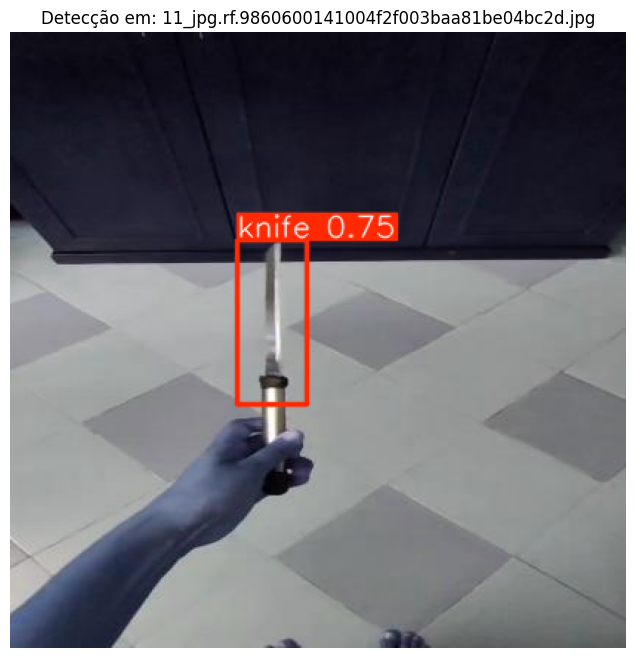


image 1/1 /content/valid/images/knife_974_jpg.rf.36d132855d448a0e0f47458bfe893f27.jpg: 640x640 1 knife, 9.6ms
Speed: 3.4ms preprocess, 9.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


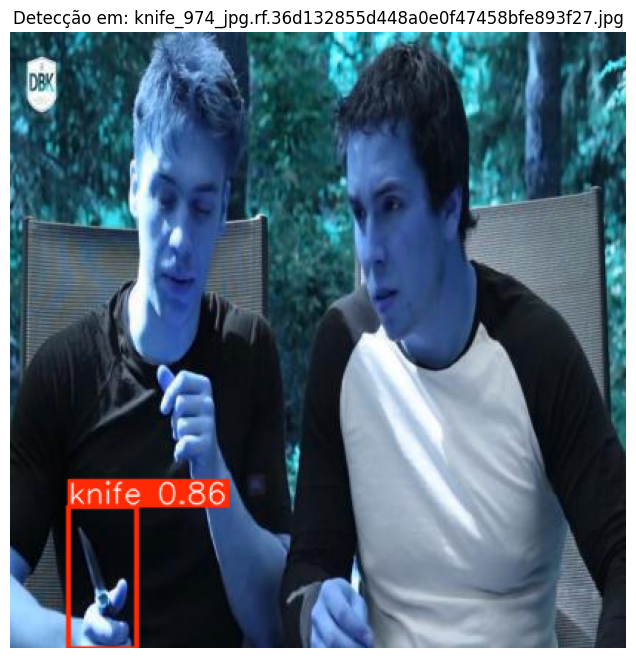


image 1/1 /content/valid/images/1649338732-1588159_jpg.rf.babfa84cb5d9f295a6966ad13233da3c.jpg: 640x640 1 knife, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


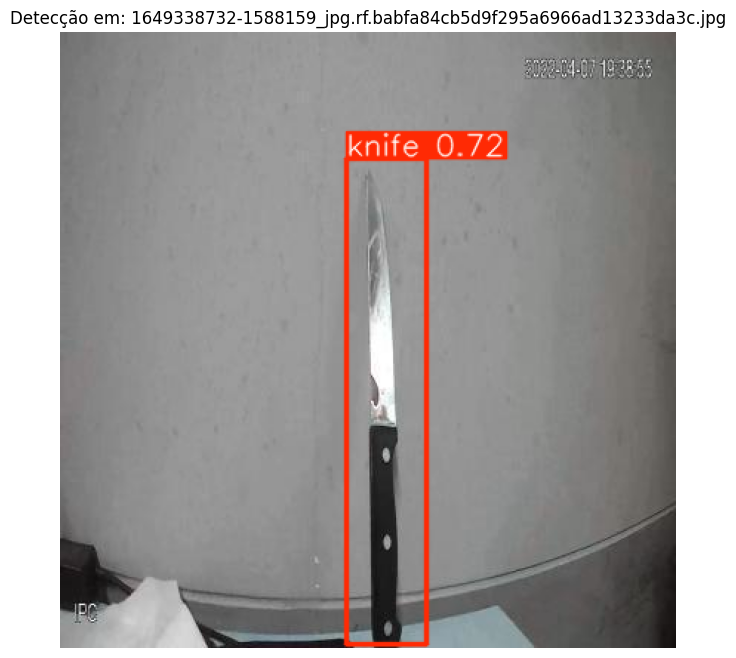

In [7]:
import matplotlib.pyplot as plt

# Obter algumas imagens do conjunto de validação para teste visual
validation_images = get_image_files('/content/valid')[:3]  # Ajuste o caminho conforme necessário

# Realiza a detecção e exibe as imagens com resultados
for img_path in validation_images:
    results = model(img_path)
    results_plotted = results[0].plot()

    plt.figure(figsize=(8, 8))
    plt.imshow(results_plotted)
    plt.axis('off')
    plt.title(f"Detecção em: {os.path.basename(img_path)}")
    plt.show()
